# 3-Way Voting Ensemble SHAP Exploration

In [1]:
import sys
sys.path.append('../')

import sklearn
import shap
from sklearn.model_selection import train_test_split
import xgboost as xgb
from preprocess.load_data import load_expanded

# Load data
x, y, ids = load_expanded(return_pandas=True, reduced_features=False)
X_train,X_test,Y_train,Y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# print the JS visualization code to the notebook
shap.initjs()

In [10]:
x, y, ids = load_expanded(return_pandas=True, reduced_features=False)
x_reduced, _, _ = load_expanded(return_pandas=True, reduced_features=True)

print('Number of expanded features: ', len(x.columns))
print('Number of reduced features: ', len(x_reduced.columns))

# Features that are only in expanded dataset
print(set(x.columns) - set(x_reduced.columns))

Number of expanded features:  32
Number of reduced features:  18
{'eth_hispanic', 'age', 'abc', 'eth_american_indian', 'eth_multiracial', 'peeling', 'eth_asian', 'pua', 'palbumin', 'gender', 'eth_black', 'eth_pacific_islander', 'eth_caucasian', 'anc'}


In [ ]:
### RANDOM FOREST ###

# # train a RF classifier
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier()
# rf.fit(X_train, Y_train)

# # use SHAP to explain test set predictions
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_test)

# # plot the SHAP values for the Setosa output of the first instance
# shap.summary_plot(shap_values, X_test)

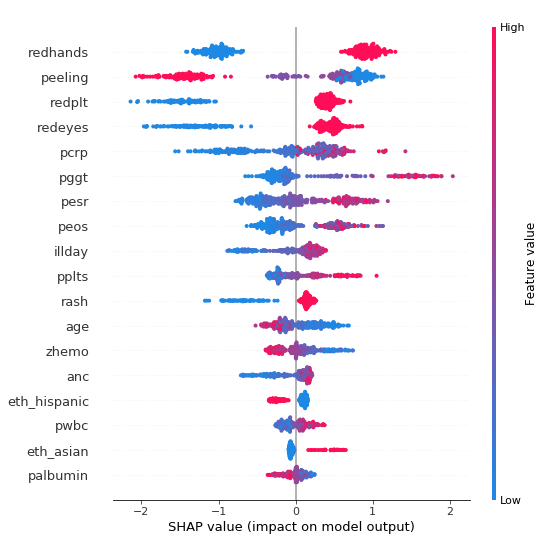

In [23]:
### XGBOOST ###

# train a XGB classifier
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
xgb_explainer = shap.TreeExplainer(xgboost)
xgb_shap_values = xgb_explainer.shap_values(X_test)

# plot the SHAP values summary
shap.summary_plot(xgb_shap_values, X_test, max_display=18, plot_type='dot')

Using 1081 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 361/361 [02:59<00:00,  2.01it/s]


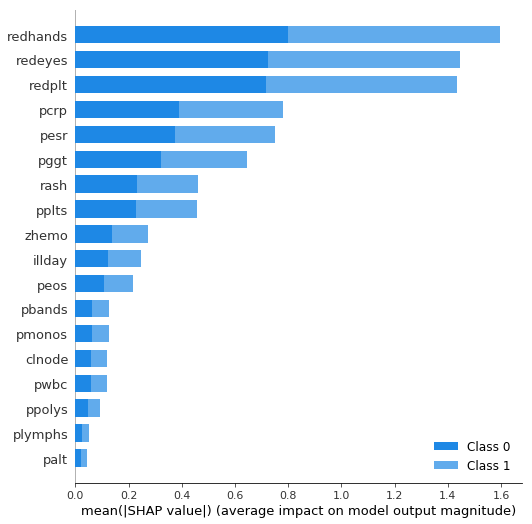

In [5]:
### LOGISTIC REGRESSION ###

# train a LR classifier
lr = sklearn.linear_model.LogisticRegression()
lr.fit(X_train, Y_train)

# use SHAP to explain test set predictions
lr_explainer = shap.KernelExplainer(lr.predict_proba, X_train, link="logit")
lr_shap_values = lr_explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values summary
shap.summary_plot(lr_shap_values, X_test)

Using 1081 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

 85%|████████▍ | 306/361 [07:16<01:18,  1.43s/it]


100%|██████████| 361/361 [08:35<00:00,  1.43s/it]


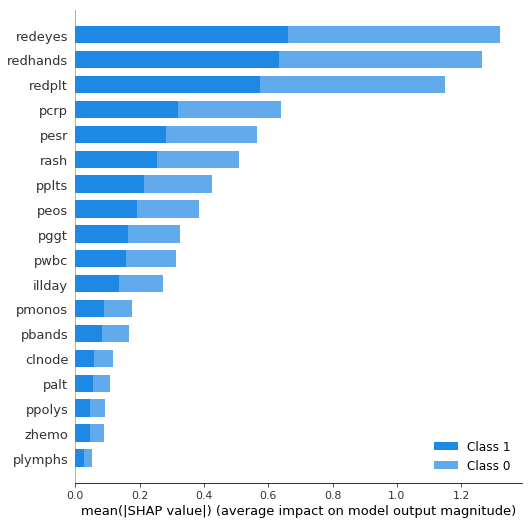

In [16]:
### SVM ###

# train a SVM classifier
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values summary
shap.summary_plot(shap_values, X_test)

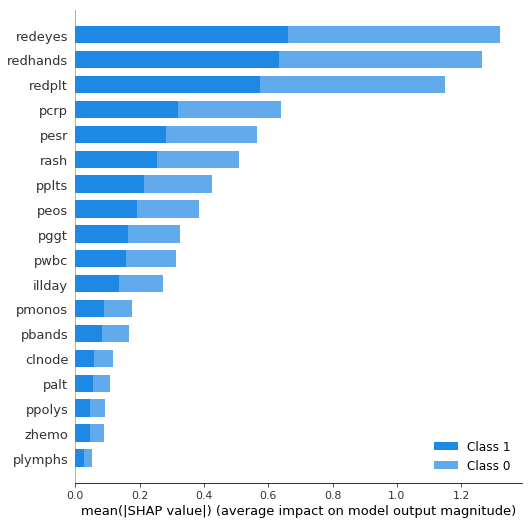

In [18]:
shap.summary_plot(shap_values, X_test)

In [15]:
### VOTING CLASSIFIER ###
from sklearn.ensemble import VotingClassifier

# Train voting classifier
clf1 = sklearn.svm.SVC(probability=True)
clf2 = sklearn.linear_model.LogisticRegression()
clf3 = xgb.XGBClassifier()

voting = VotingClassifier(
        estimators=[
            ('svm', clf1), 
            ('lr', clf2),
            ('xgb', clf3)
        ],
    voting='soft')

voting.fit(X_train.values, Y_train.values)

# use SHAP to explain test set predictions
voting_explainer = shap.KernelExplainer(voting.predict_proba, X_train.values, link="logit")
voting_shap_values = voting_explainer.shap_values(X_test.values, nsamples=100)

/Users/lucashu/anaconda/envs/kd/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using 1081 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 361/361 [16:05<00:00,  2.68s/it]


TypeError: summary_plot() got multiple values for argument 'features'

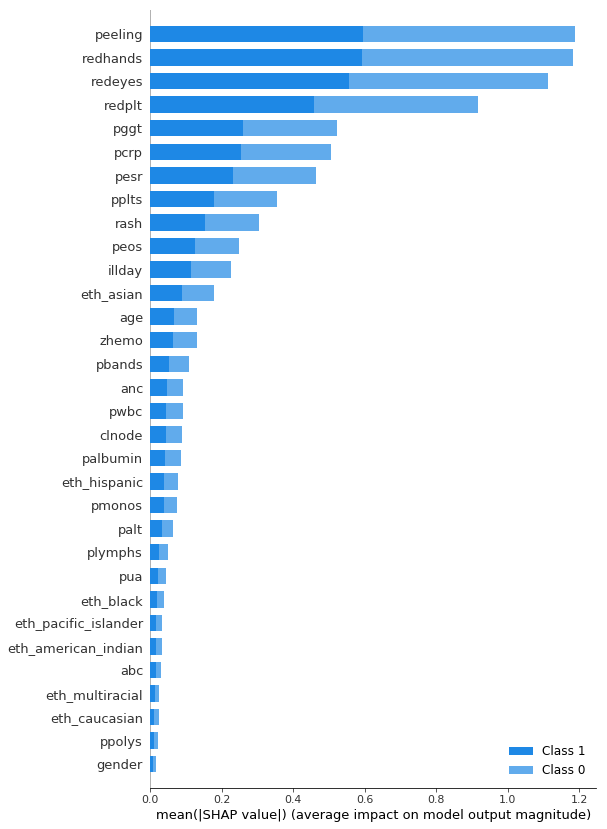

In [24]:
# plot the SHAP values summary
shap.summary_plot(voting_shap_values, features=X_train.columns.tolist(), max_display=36)